In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import ast


import os
import re
from matplotlib import pyplot as plt
import seaborn as sns

/Users/fatemehshah-mohammadi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Convert string to list
def str_to_list(x):

    return ast.literal_eval(x)


def most_comm(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

def least_common(x):
#     print(x.most_common(1)[0])
    c = x.most_common(1)[0]
#     print(c[1])
    if c[0].lower() == 'yes':
        return ('No',30-c[1])
    else:
        return ('Yes',30-c[1])
    
import math

def normalized_yes_probability(lst):
    
    
    top_prediction_and_normalized_prob = []
    
    
    y_n_o_probs_all = []
    
    for entries in lst:
        y_n_o_probs = []
        # Convert logprobs to standard probabilities
        probs = [(text, math.exp(logprob)) for text, logprob in entries]
        
        # Total probability for normalization
        total_prob = sum(prob for _, prob in probs)
        
        # Sum of probabilities for entries containing "yes" (case-insensitive)
        yes_prob = sum(prob for text, prob in probs if 'yes' in text.lower())
       
        
        # Sum of probabilities for entries containing "no" (case-insensitive)
        no_prob = sum(prob for text, prob in probs if 'no' in text.lower())
       
        
        # Normalized probability
        y_n_o_probs.append(no_prob / total_prob if total_prob > 0 else 0.0)
        y_n_o_probs.append(yes_prob / total_prob if total_prob > 0 else 0.0)
        o_prob = 1- y_n_o_probs[0] - y_n_o_probs[1]
        y_n_o_probs.append (o_prob)
#         print('yes no other prob: ', y_n_o_probs)
        
        y_n_o_probs_all.append(y_n_o_probs)
       
        #print('all:  ', y_n_o_probs_all)
#         input()


        
        top_pred = max(probs, key=lambda x: x[1])
        if False:
            print('Top 10 logprobs:\n', entries, '\n')
            print('Top 10 logprobs => probs:\n', probs, '\n')
            print('total of all 10 probs for normalization:\n', total_prob, '\n')
            print('yes prob (sum of all containing yes):\n', yes_prob, '\n')
            print('text + prob (max among those containing yes):\n', max([x for x in probs if 'yes' in x[0].lower()], key=lambda x: x[1]), '\n')
            print('no prob (sum of all containing no):\n', no_prob, '\n')
            print('text + prob (max among those containing no):\n', max([x for x in probs if 'no' in x[0].lower()], key=lambda x: x[1]), '\n')
            print('Response with Max Probability:\n\n', top_pred, '\n')
        # normalize prob
        top_pred = (top_pred[0], (top_pred[1] / (total_prob if total_prob > 0 else 1)))
        top_prediction_and_normalized_prob.append(top_pred)

        
        
    return y_n_o_probs_all
    # return y_n_o_probs_all, top_prediction_and_normalized_prob


def sample_final_prediction(lst):
    l=[]
    for item in lst:
        l.append(item.index(max(item)))
#     print(l)
    return l   

def true_class_prob (x):
    return [sublist[x[1]] for sublist in x[0]]
    

In [3]:
cal = pd.read_csv('calibration_gpt_temp_1_v2.csv').drop('Unnamed: 0', axis=1)
print(len(cal))
print(cal.groupby('HOSPITAL_EXPIRE_FLAG').size())
# cal.head(2)

677
HOSPITAL_EXPIRE_FLAG
0    349
1    328
dtype: int64


In [4]:
def calc_non_conformity(data):
#     print(data.groupby('HOSPITAL_EXPIRE_FLAG').size())
#     print(len(data['prediction_logprob'].apply(str_to_list).iloc[0]), len(data['prediction_logprob'].apply(str_to_list).iloc[0][0]))

    data['prediction_logprob'] = data['prediction_logprob'].apply(str_to_list)
    data ['y_n_o_probs_all'] = data['prediction_logprob'].apply(normalized_yes_probability)
    # sample_final_prediction(data ['y_n_o_probs_all'][0])
    data ['sample_final_prediction'] = data ['y_n_o_probs_all'].apply(sample_final_prediction)
    data ['final_prediction'] = data ['sample_final_prediction'].apply(most_comm)
    data['HOSPITAL_EXPIRE_FLAG_CAT']= data['HOSPITAL_EXPIRE_FLAG'].apply(lambda x: 'Yes' if x==1 else 'No')
    data['true_class_prob'] = data[['y_n_o_probs_all','HOSPITAL_EXPIRE_FLAG']].apply(true_class_prob,axis=1)
    data['nonconformity_scores'] = data['true_class_prob'].apply(lambda lst: [1-p for p in lst])
    return data



In [5]:
cal = calc_non_conformity(cal)
# cal.head(2)

In [6]:
all_nonconformity_scores = sum(cal['nonconformity_scores'], [])

In [7]:
# extract the two groups and flatten 30 scores per row into single list
scores0 = sum(cal.loc[cal['HOSPITAL_EXPIRE_FLAG'] == 0, 'nonconformity_scores'], [])
scores1 = sum(cal.loc[cal['HOSPITAL_EXPIRE_FLAG'] == 1, 'nonconformity_scores'], [])
all_nonconformity_scores = scores0 + scores1

In [8]:
print(len(cal[cal['HOSPITAL_EXPIRE_FLAG'] == 0]['len_text_2']))
cal['mean_nonconformity_scores'] = cal['nonconformity_scores'].apply(lambda x: np.mean(x))
len(cal[cal['HOSPITAL_EXPIRE_FLAG'] == 0]['mean_nonconformity_scores'])

349


349

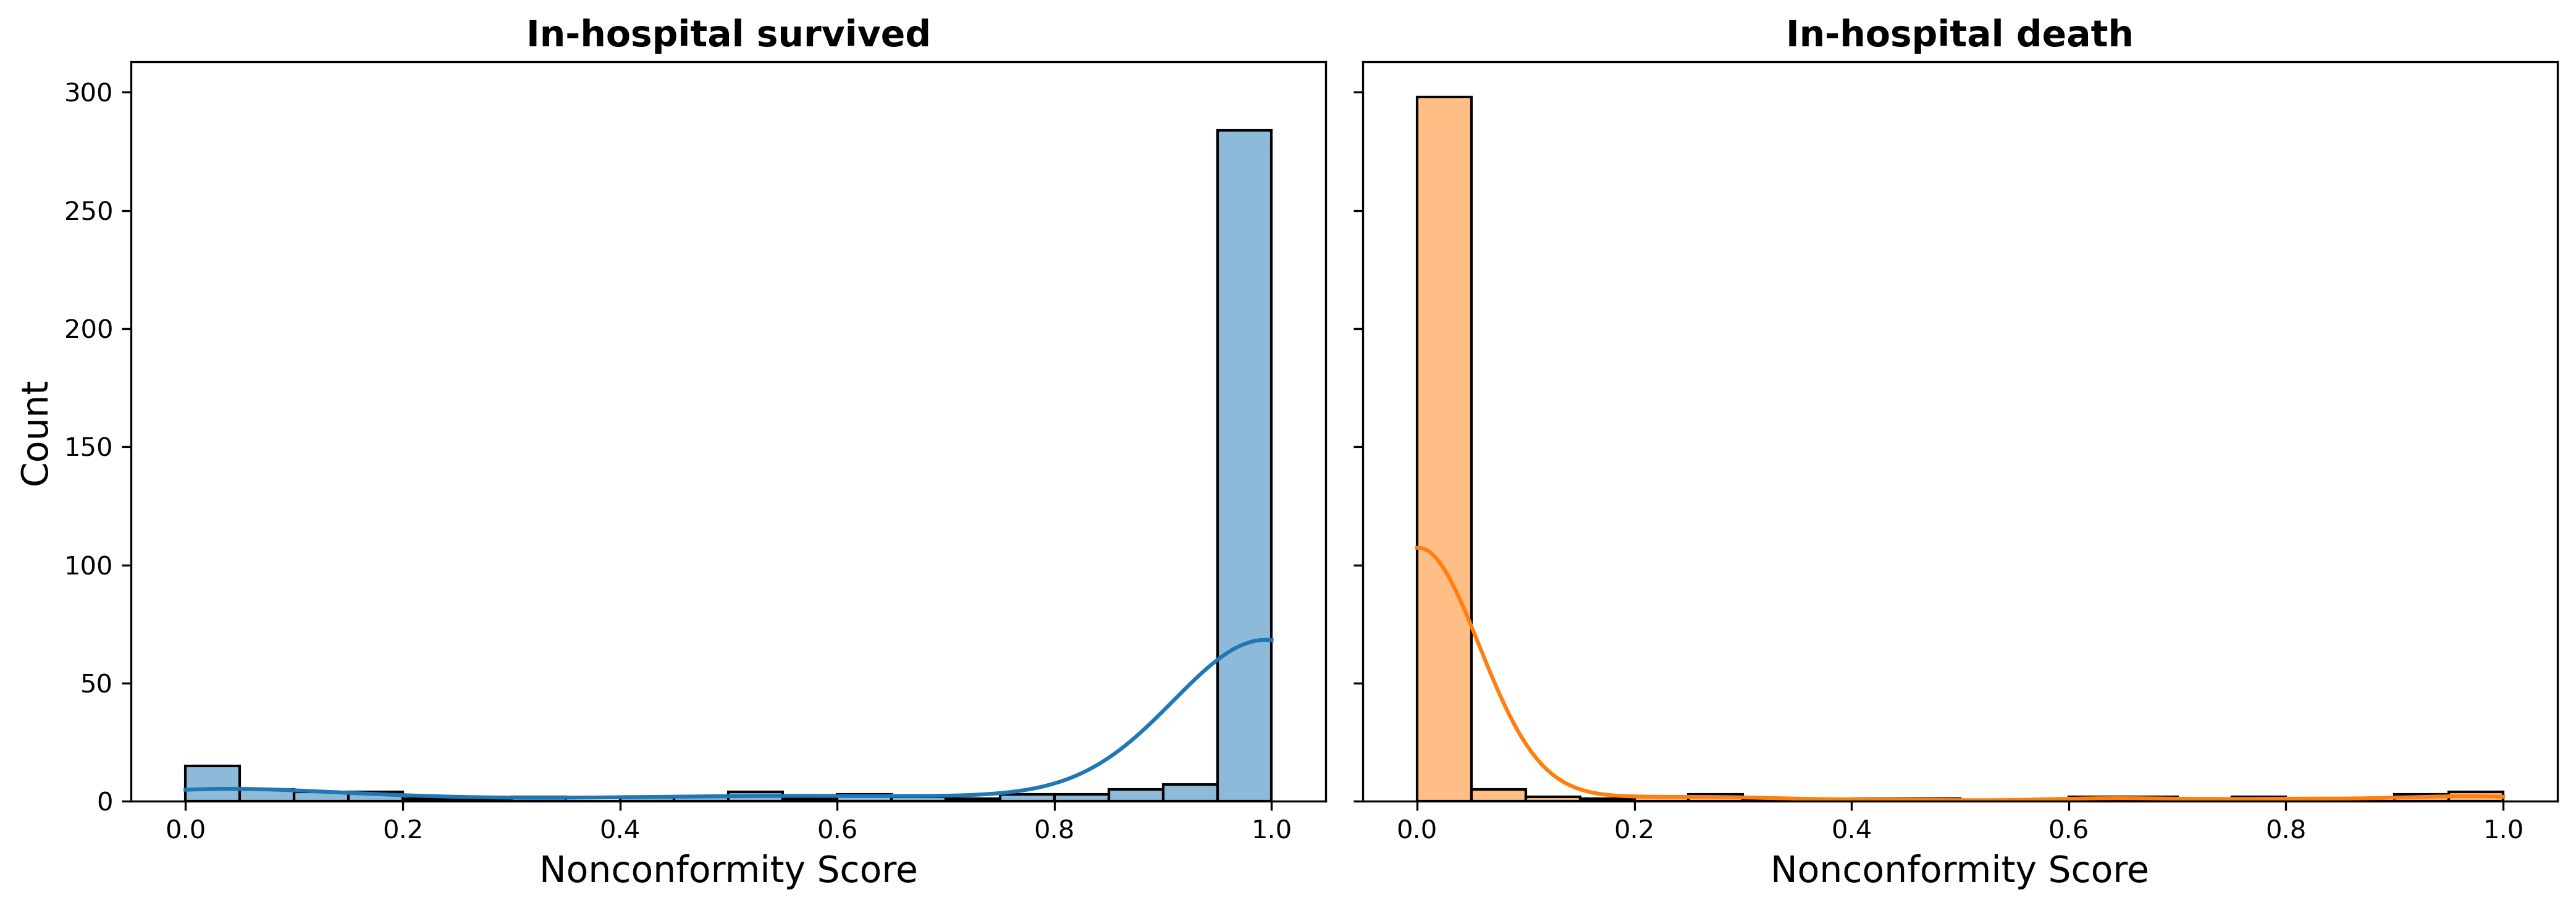

In [9]:
# 1) Histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=300, sharey=True)
sns.histplot(cal[cal['HOSPITAL_EXPIRE_FLAG'] == 0]['mean_nonconformity_scores'], bins=20, kde=True, ax=axes[0], color='C0')
axes[0].set_title('In-hospital survived',fontdict={'size': 14, 'weight': 'bold'})
axes[0].set_xlabel('Nonconformity Score',fontdict={'size': 14})
axes[0].set_ylabel('Count',fontdict={'size': 14})
sns.histplot(cal[cal['HOSPITAL_EXPIRE_FLAG'] == 1]['mean_nonconformity_scores'], bins=20, kde=True, ax=axes[1], color='C1')
axes[1].set_title('In-hospital death',fontdict={'size': 14, 'weight': 'bold'})
axes[1].set_xlabel('Nonconformity Score',fontdict={'size': 14})
plt.tight_layout()
plt.savefig('Mean_non_conform_flag.jpg')

plt.show()

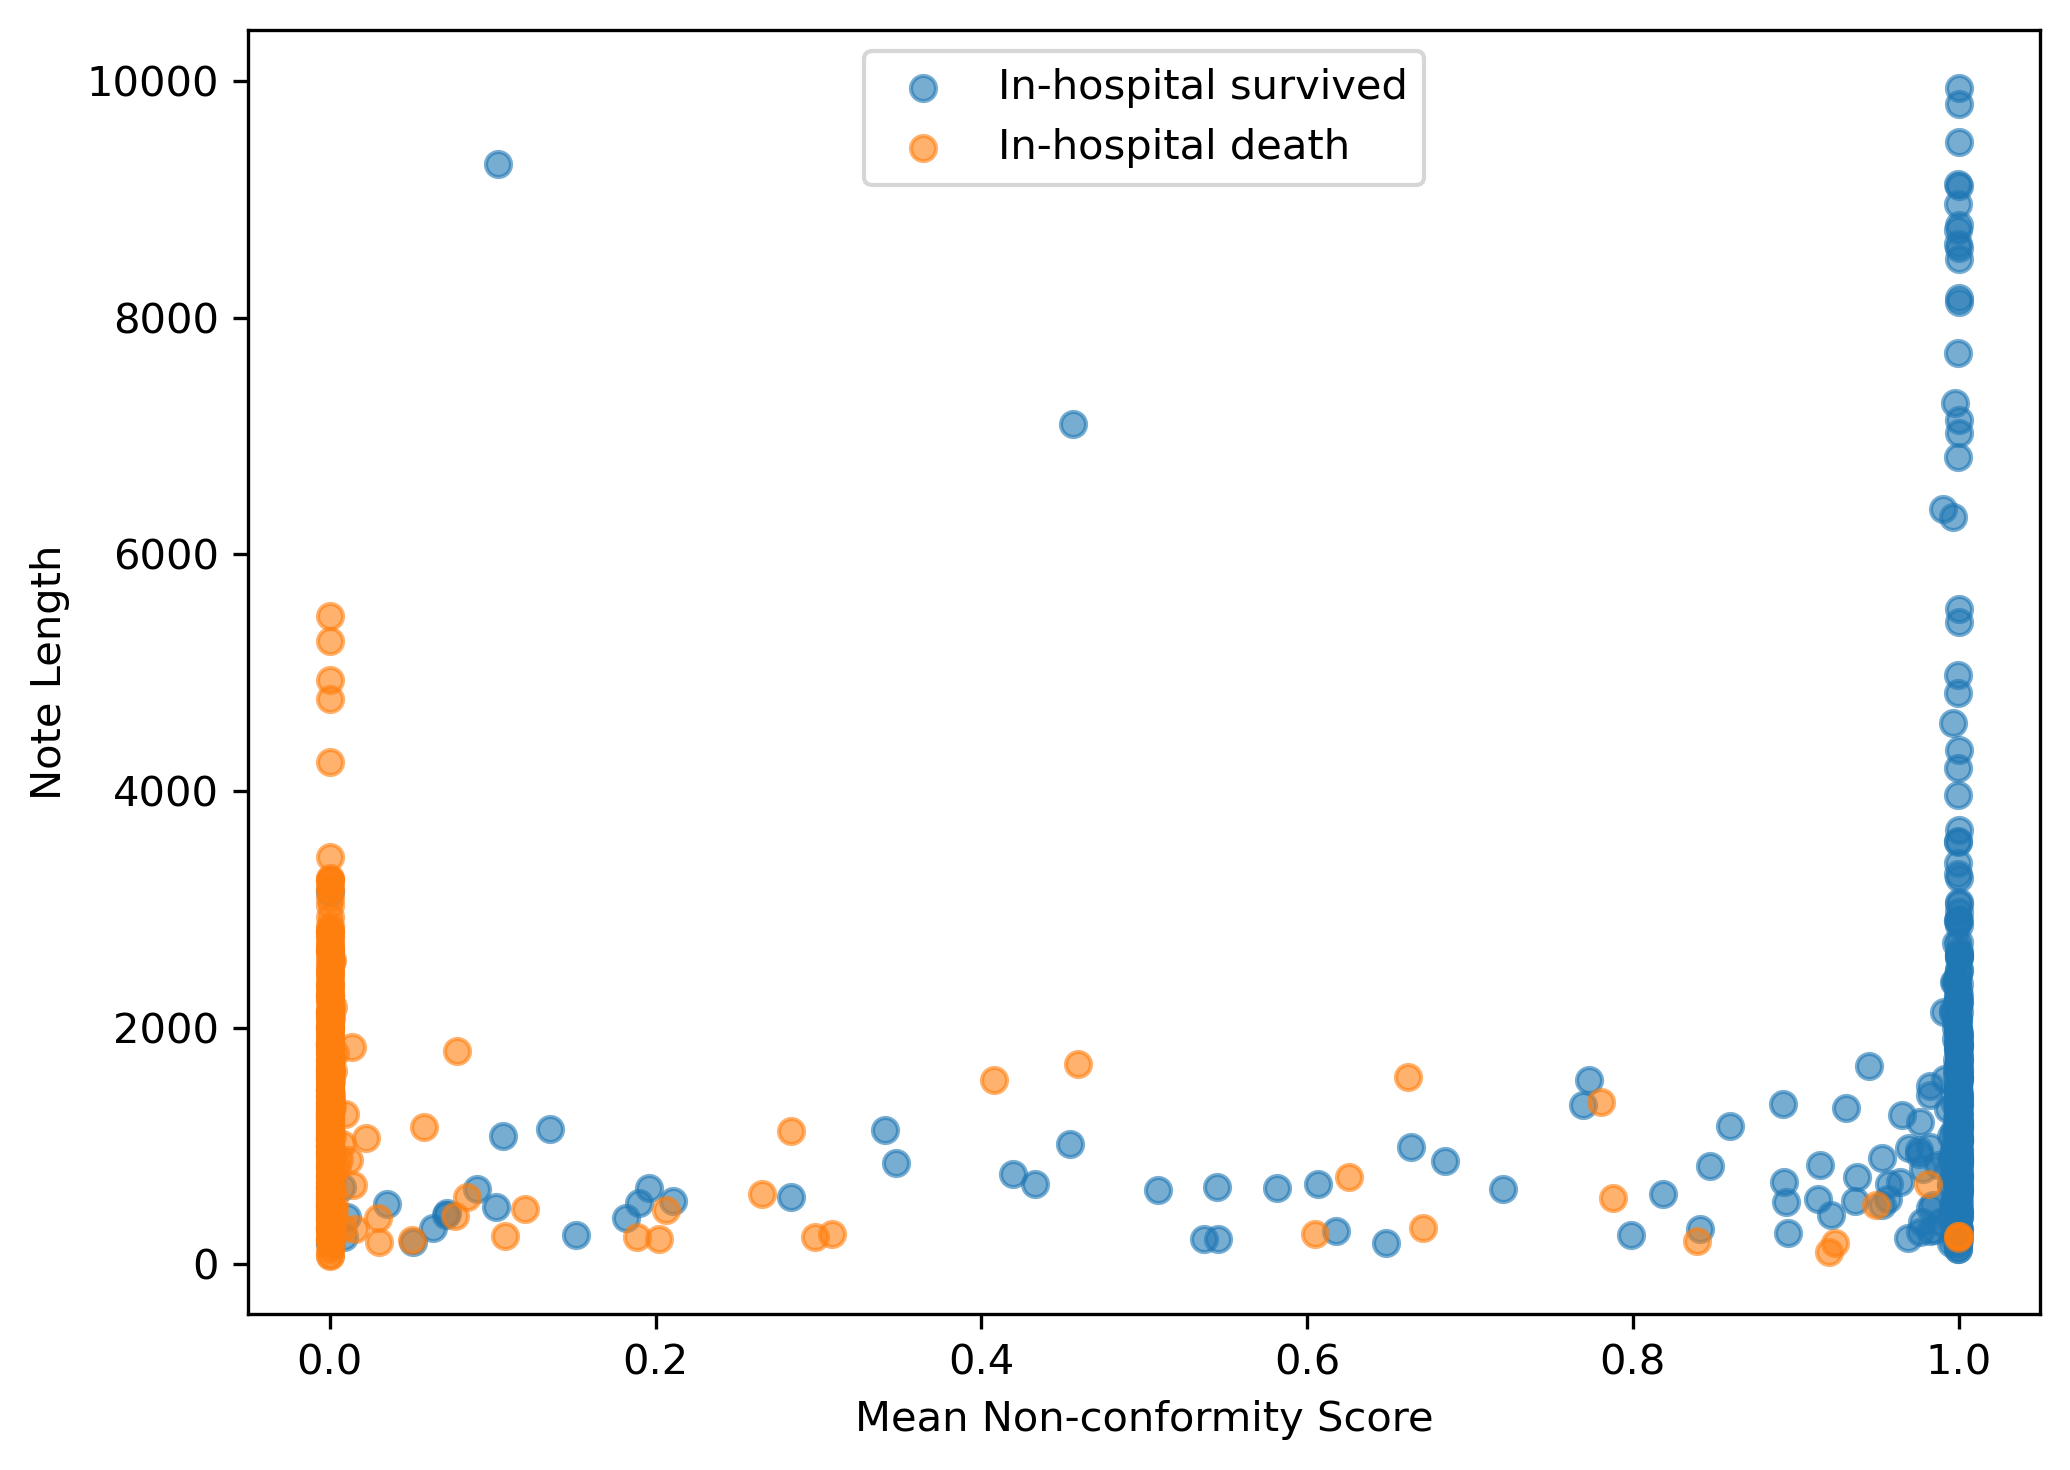

In [10]:

plt.figure(figsize=(7, 5), dpi=300)

# Scatter plot for HOSPITAL_EXPIRE_FLAG = 0
plt.scatter(
    cal[cal['HOSPITAL_EXPIRE_FLAG'] == 0]['mean_nonconformity_scores'],
    cal[cal['HOSPITAL_EXPIRE_FLAG'] == 0]['len_text_2'],
    alpha=0.6,
    label='In-hospital survived'
)

# Scatter plot for HOSPITAL_EXPIRE_FLAG = 1
plt.scatter(
    cal[cal['HOSPITAL_EXPIRE_FLAG'] == 1]['mean_nonconformity_scores'],
    cal[cal['HOSPITAL_EXPIRE_FLAG'] == 1]['len_text_2'],
    alpha=0.6,
    label='In-hospital death'
)

plt.xlabel('Mean Non-conformity Score')
plt.ylabel('Note Length')
# plt.title('Note Length vs. Mean Non-conformity Score by Mortality Flag')
plt.legend()
plt.tight_layout()
plt.savefig('note_length_non_conform_flag.jpg')
plt.show()

## Test

In [12]:
test = pd.read_excel('test_gpt_temp_1_v2.xlsx').drop (['Unnamed: 0'], axis=1)
test.head(2)

,SUBJECT_ID,HADM_ID,FIRST_24H_TEXT,len_text_2,ROW_ID_x,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,SEQ_NUM,ICD9_CODE,len_code,HOSPITAL_EXPIRE_FLAG_CAT,prediction_logprob,y_n_o_probs_all,sample_final_prediction,final_prediction,true_class_prob,nonconformity_scores
0,9504,147133,[**Wardname **] 4 7p-7apt received to unit at ...,247,11632,2144-03-22 15:31:00,2144-03-30 12:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,...,11,5849,4,No,"[[('No', -0.6931476593017578), ('Yes', -0.6931...","[[0.4999999934741123, 0.49999994528342073, 6.1...","[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, ...",0,"[0.4999999934741123, 0.5621764741755622, 0.562...","[0.5000000065258877, 0.43782352582443784, 0.43..."
1,3830,168714,condition updatesee carevue for all specifics;...,313,4598,2169-08-11 01:59:00,2169-08-25 03:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,...,3,5849,4,No,"[[('Yes', -0.000431861262768507), ('No', -7.75...","[[0.0004305565795992501, 0.9995693055767894, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[0.0004305565795992501, 0.0005527783101222264,...","[0.9995694434204008, 0.9994472216898778, 0.999..."


In [13]:
test = calc_non_conformity(test)
print(len(test))
print(test.groupby('HOSPITAL_EXPIRE_FLAG').size())
# test.head(2)

677
HOSPITAL_EXPIRE_FLAG
0    336
1    341
dtype: int64


In [14]:
# cal nonconformity scores
cal_ncs = [score for sublist in cal['true_class_prob'].apply(lambda x: [1-p for p in x]) for score in sublist]

# print(cal_ncs)

class PredictionClass:
    def __init__(self, p, eps):
        self.p = p
        self.eps = eps

    def classes(self, eps=None):
        if eps is None:
            eps = self.eps
            assert(eps is not None)
        return [y for p_y, y in self.p if p_y > eps]

    def verdict(self, ref, eps=None):
        return ref in self.classes(eps)

    def confidence(self):
        return 1-sorted([p_y for p_y, y in self.p], reverse=True)[1]

    def credibility(self):
        return max(p_y for p_y, y in self.p)

    
    
    
def conformal_prediction(cal_scores, test_in, alpha=0.1, verbose=True):
    # Make a copy of test_in to not mutate input df
    test = test_in.copy()
    
    # Convert test probabilities to a numpy array.
    preds = test[['no', 'yes', 'other']].to_numpy()
    
    # Build prediction results with a nested list comprehension.
    prediction_results = [
        PredictionClass(
            [
                (
                    #                      vvvvvvvv  using inverse probability nonconformity measure
                    (np.sum(cal_scores >= (1 - pred)) + 1) / (len(cal_scores) + 1),
                    cls
                )
                for cls, pred in enumerate(example)
            ],
            eps=alpha
        )
        for example in preds
    ]
    
    # Assign the PredictionClass results and compute the other columns.
    test['confidence'] = [cp.confidence() for cp in prediction_results]
    test['credibility'] = [cp.credibility() for cp in prediction_results]
    test['classes'] = [cp.classes() for cp in prediction_results]
    test['verdict'] = [cp.verdict(cls) for cp, cls in zip(prediction_results, test['class'])]
    test['cp'] = prediction_results


    # Calculate and print empirical coverage and avg prediction set size if verbose is enabled.
    if verbose:        
        empirical_coverage = test['verdict'].mean()
        print(f"The empirical coverage is: {100 * empirical_coverage:.2f}%")
        
        # if class_conditional:
        # Compute empirical coverage per class.
        coverage_by_class = test.groupby('class')['verdict'].mean()
        for cls, coverage in coverage_by_class.items():
            print(f"Empirical coverage for class {cls}: {100 * coverage:.2f}%")
    
        pred_set_size = test['classes'].apply(len).mean()
        print(f"Mean prediction set size is: {pred_set_size:.2f}")
        
        # Compute mean prediction set size per class.
        pred_set_size_by_class = test.groupby('class')['classes'].apply(
            lambda x: x.map(len).mean()
        )
        for cls, ps_size in pred_set_size_by_class.items():
            print(f"Mean prediction set size for class {cls}: {ps_size:.2f}")
        print()
    
    return test




def conformal_prediction_quantile_based(cal_scores, test, alpha=0.1, verbose=True):
    # get the adjusted quantile
    n = len(cal_scores)
    q_level = np.ceil((n+1)*(1-alpha))/n
    qhat = np.quantile(cal_scores, q_level, method='higher')
        
    # form conformal prediction sets
    pred_sets = test[['no', 'yes', 'other']] >= (1 - qhat)
        
    # Calculate empirical coverage
    empirical_coverage = pred_sets.to_numpy()[np.arange(pred_sets.shape[0]),test['class']].mean()

    if verbose:
        print(f'qhat: {qhat}\n')
        print(pred_sets.apply(lambda x: int(x['no']) + int(x['yes']) + int(x['other']), axis=1).value_counts())
        print(f"\nThe empirical coverage is: {empirical_coverage:.3f}\n\n")
        
    return pred_sets






df = pd.DataFrame({'true_class_prob': test['true_class_prob']})
df['true_class_prob'] = df['true_class_prob'].apply(np.mean)
df[['no', 'yes', 'other']] = test['y_n_o_probs_all'].apply(
    lambda probs: pd.Series(np.mean(probs, axis=0))
)
df['class'] = test['HOSPITAL_EXPIRE_FLAG']
df['predicted_class'] = test['final_prediction']
print(df.iloc[0])
print('\n\nConformal Prediction:\n-----------------------------------')
cp = conformal_prediction(cal_ncs, df, alpha=0.1, verbose=True)
print('\n\nConformal Prediction - Quantile Based\n-----------------------------------')
cpq = conformal_prediction_quantile_based(cal_ncs, df, alpha=0.1, verbose=True)
print('mean prediction set size:', f'{cpq.sum(axis=1).mean():.2f}')
print('pred sets w/more than 1 label:', (cpq.sum(axis=1) > 1).sum())
print('pred sets w/singleton prediction:', (cpq.sum(axis=1) == 1).sum())

true_class_prob    3.879331e-01
no                 3.879331e-01
yes                6.120666e-01
other              2.511211e-07
class              0.000000e+00
predicted_class    0.000000e+00
Name: 0, dtype: float64


Conformal Prediction:
-----------------------------------
The empirical coverage is: 92.32%
Empirical coverage for class 0: 84.82%
Empirical coverage for class 1: 99.71%
Mean prediction set size is: 1.72
Mean prediction set size for class 0: 1.84
Mean prediction set size for class 1: 1.60



Conformal Prediction - Quantile Based
-----------------------------------
qhat: 0.9999898700114127

2    486
1    191
dtype: int64

The empirical coverage is: 0.923


mean prediction set size: 1.72
pred sets w/more than 1 label: 486
pred sets w/singleton prediction: 191


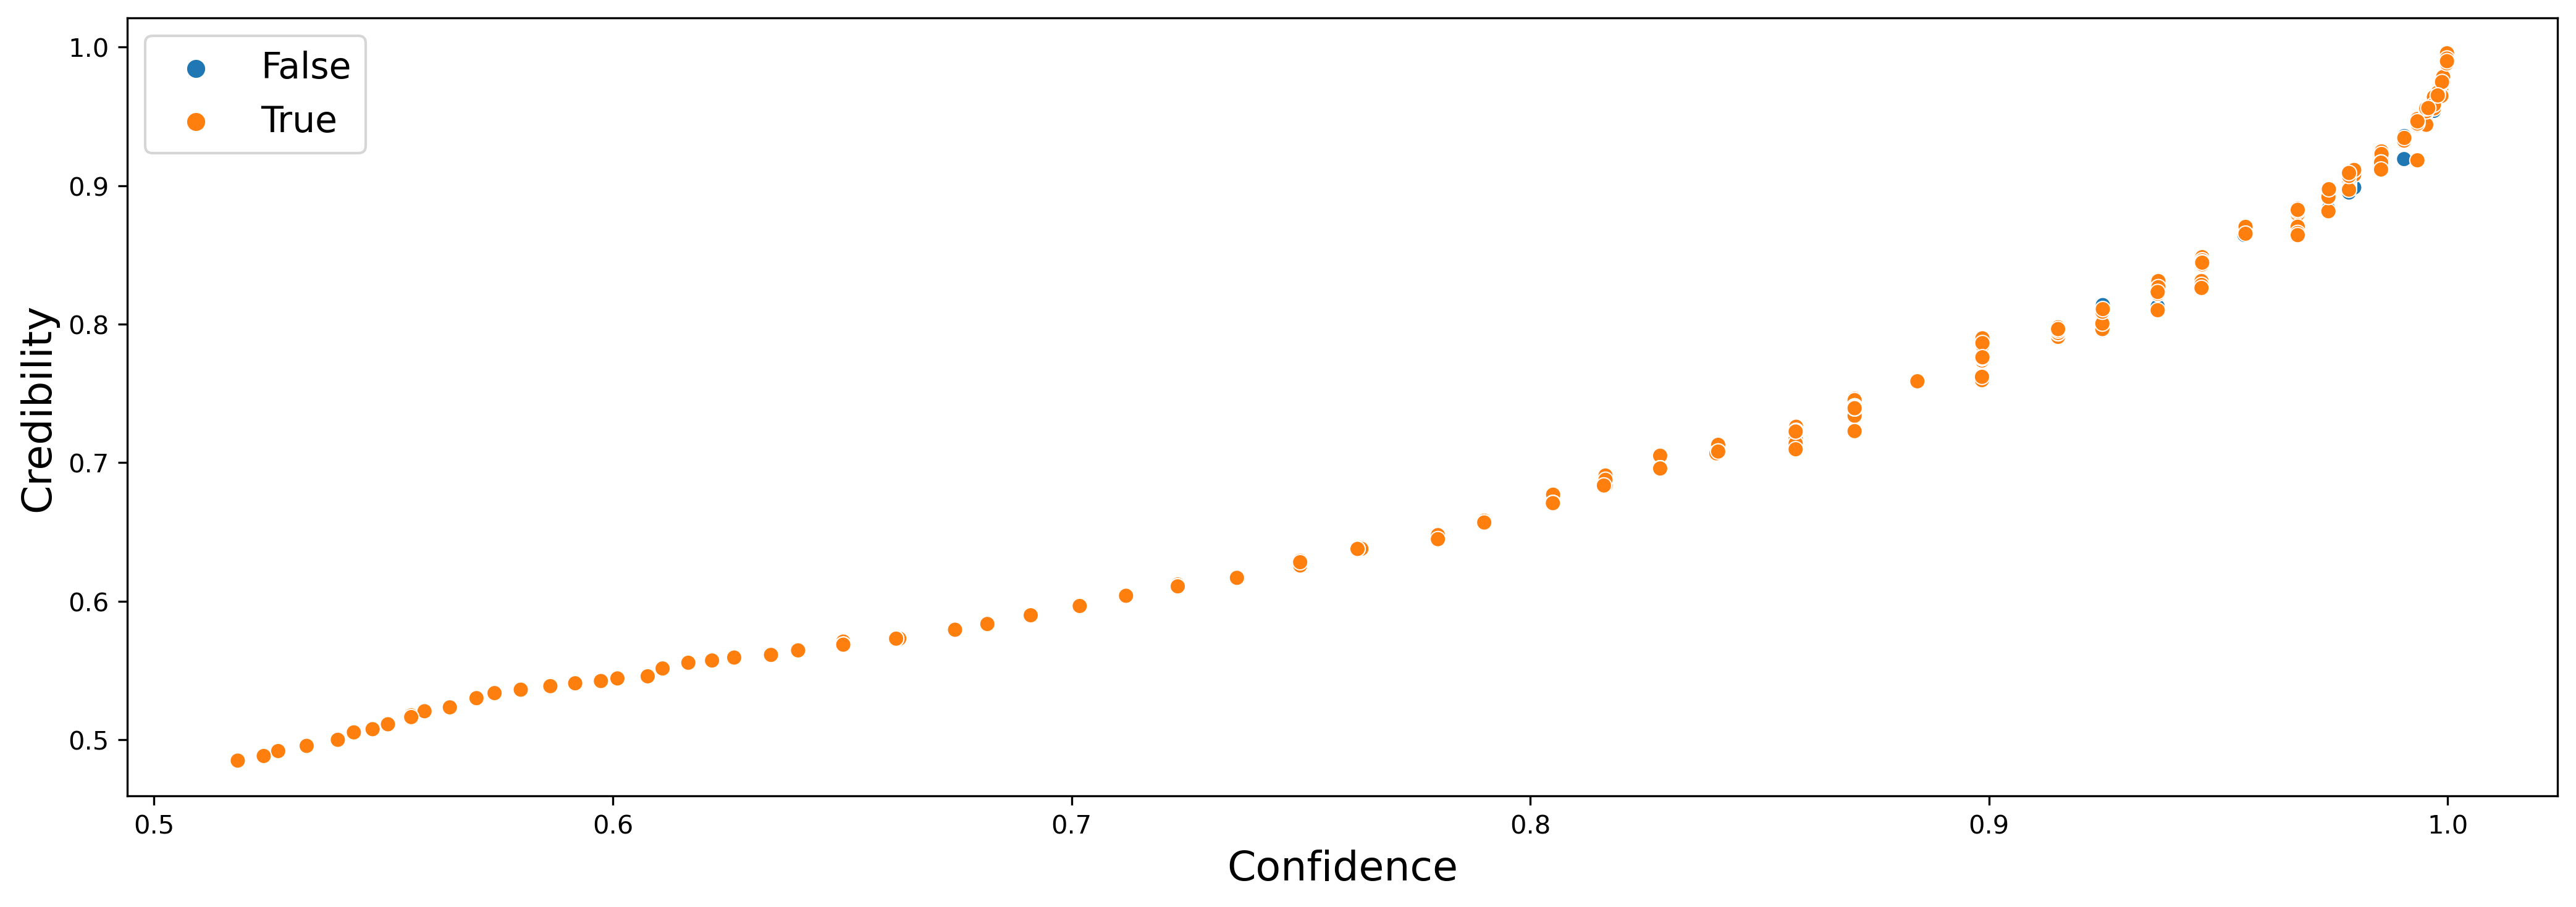

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=300)
sns.scatterplot(data=cp, x='confidence', y='credibility', hue='verdict', ax=ax)

# ax.legend(prop={'family': 'serif', 'size': 12, 'weight': 'bold'})  # You can change to desired font and size
ax.legend(prop={'size': 14})  # You can change to desired font and size


plt.xlabel("Confidence")
# plt.xlabel("Confidence", fontdict={'fontsize': 14, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel("Confidence", fontdict={'fontsize': 16})


plt.ylabel("Credibility", fontdict={'fontsize': 16})
# plt.title("Credibility vs. Confidence in GPT Predictions")
plt.tight_layout()
plt.savefig('Credibility vs. Confidence in GPT Predictions.jpg')

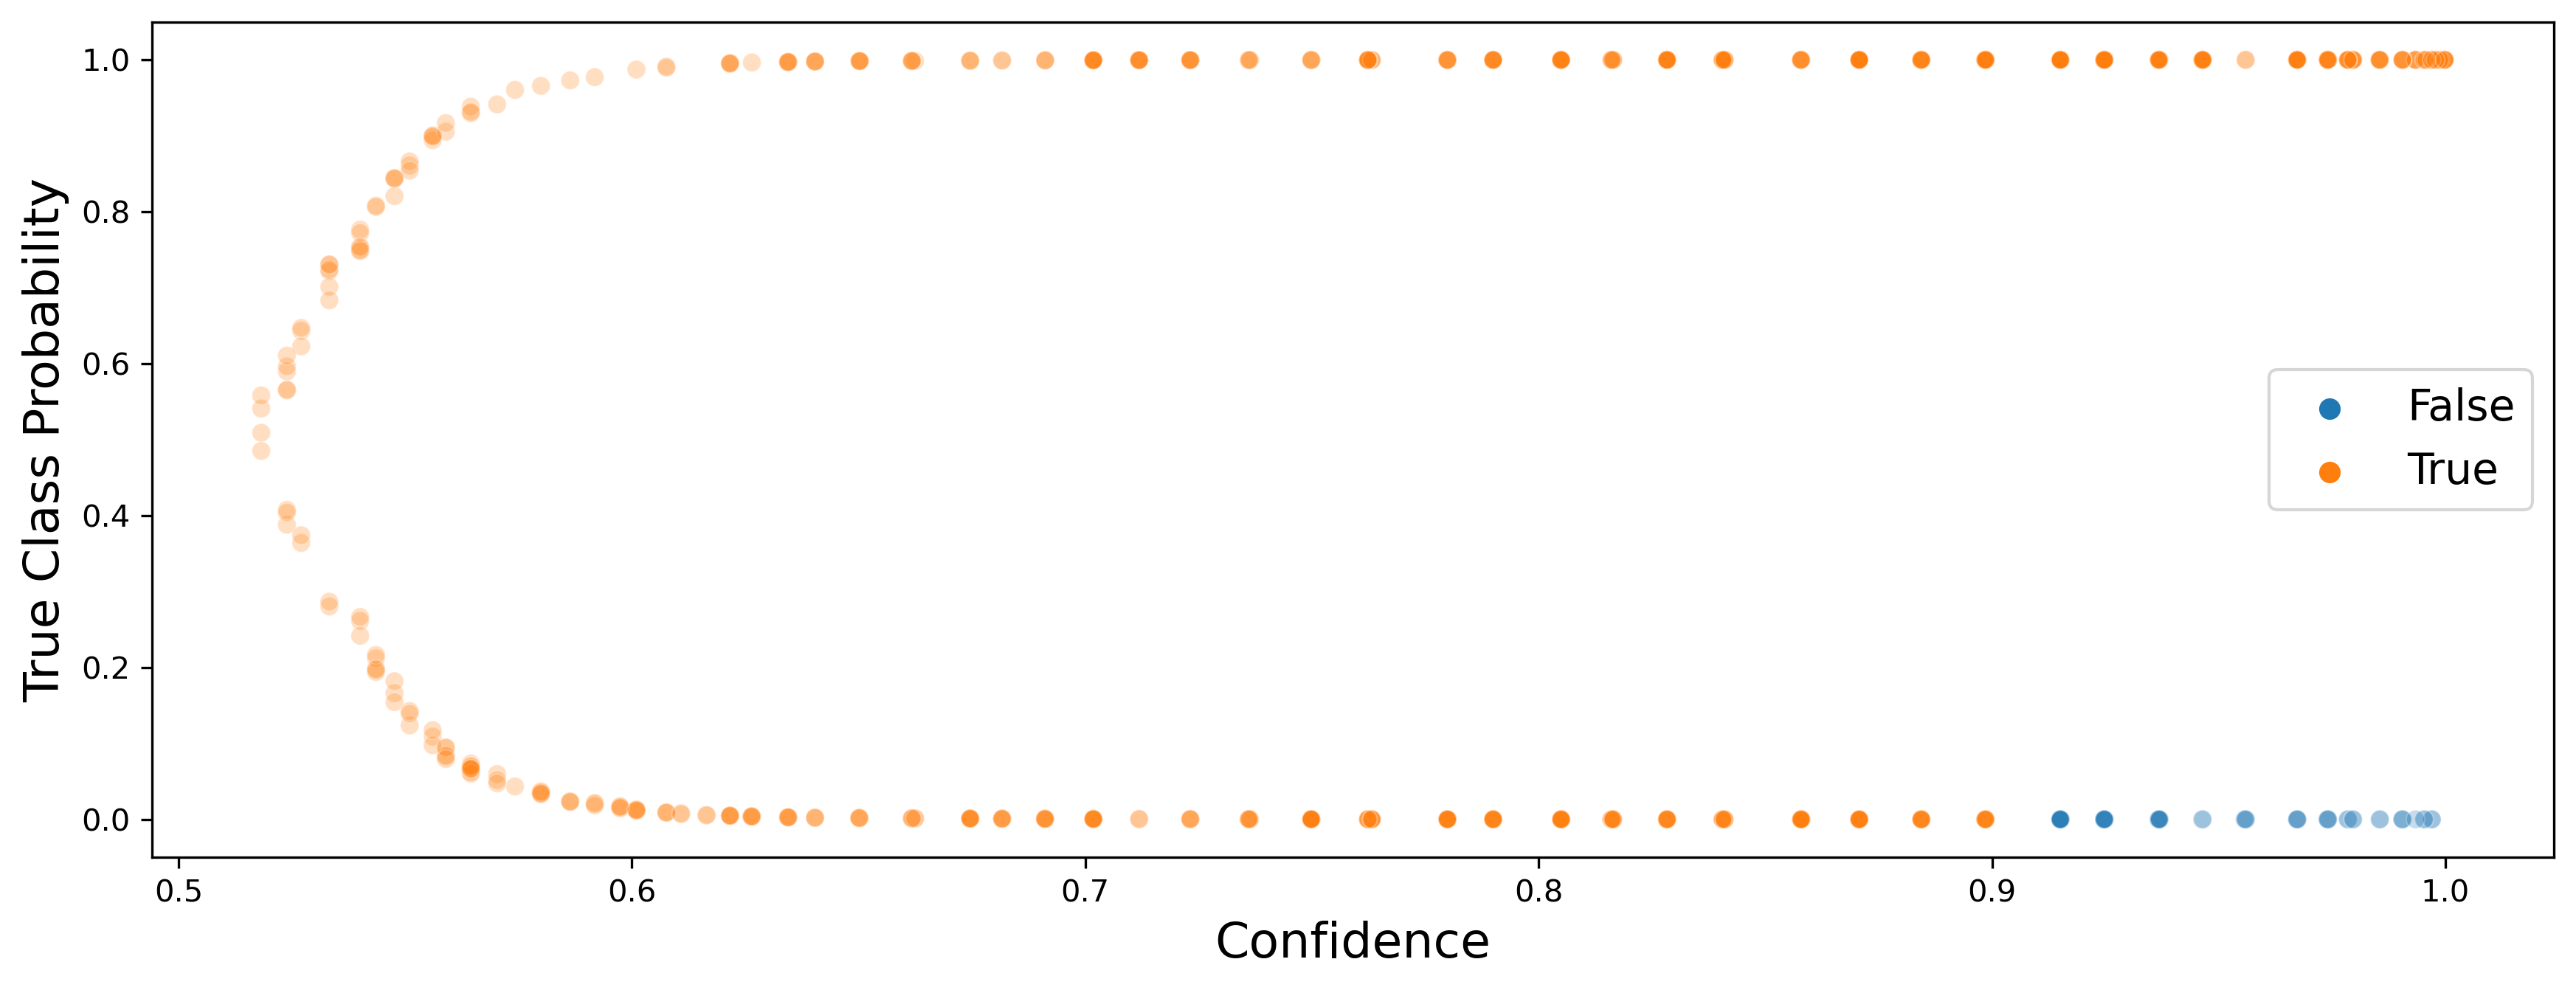

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=300)
sns.scatterplot(data=cp, x='confidence', y='true_class_prob', hue='verdict', alpha=0.25, ax=ax)
ax.legend(prop={'size': 14})  # You can change to desired font and size

plt.xlabel("Confidence", fontdict={'fontsize': 16})
plt.ylabel("True Class Probability", fontdict={'fontsize': 16})
# plt.title("Credibility vs. Confidence in GPT Predictions")
plt.savefig('Confidence vs. True Class Probability in GPT Predictions.jpg')